## MovieLens Movie Recommendation System


- Name: Kaushik Srivasan
- Branch: 4th year, School of Computing & Data Science, Sai University

For Applied Data Analytics Course, CMI

In [4]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_split
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Loading Dataset and Preprocessing

In [6]:
movies_df = pd.read_csv(r'ml_belief_2024\movies.csv')
ratings_df = pd.read_csv(r'ml_belief_2024\user_rating_history.csv')
beliefs = pd.read_csv(r'ml_belief_2024\belief_data.csv')
elicitation_set = pd.read_csv(r'ml_belief_2024\movie_elicitation_set.csv')
recommendations = pd.read_csv(r'ml_belief_2024\user_recommendation_history.csv')

## EDA

In [7]:
print("Movies Dataset Shape:", movies_df.shape)
print("\nMovies Columns:", movies_df.columns.tolist())
print("\nSample Movies Data:")
print(movies_df.head())


Movies Dataset Shape: (90638, 3)

Movies Columns: ['movieId', 'title', 'genres']

Sample Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [8]:
print("\nRatings Dataset Shape:", ratings_df.shape)
print("\nRatings Columns:", ratings_df.columns.tolist())
print("\nSample Ratings Data:")
print(ratings_df.head())


Ratings Dataset Shape: (2046124, 4)

Ratings Columns: ['userId', 'movieId', 'rating', 'tstamp']

Sample Ratings Data:
   userId  movieId  rating               tstamp
0   42170        1     4.0  1998-06-18 16:31:37
1   42170        7     4.0  1998-06-18 16:31:37
2   42170       17     4.0  1998-06-18 16:31:37
3   42170       24     2.0  1997-11-07 13:41:17
4   42170       36     2.0  1997-11-07 13:27:51



Genre Distribution:


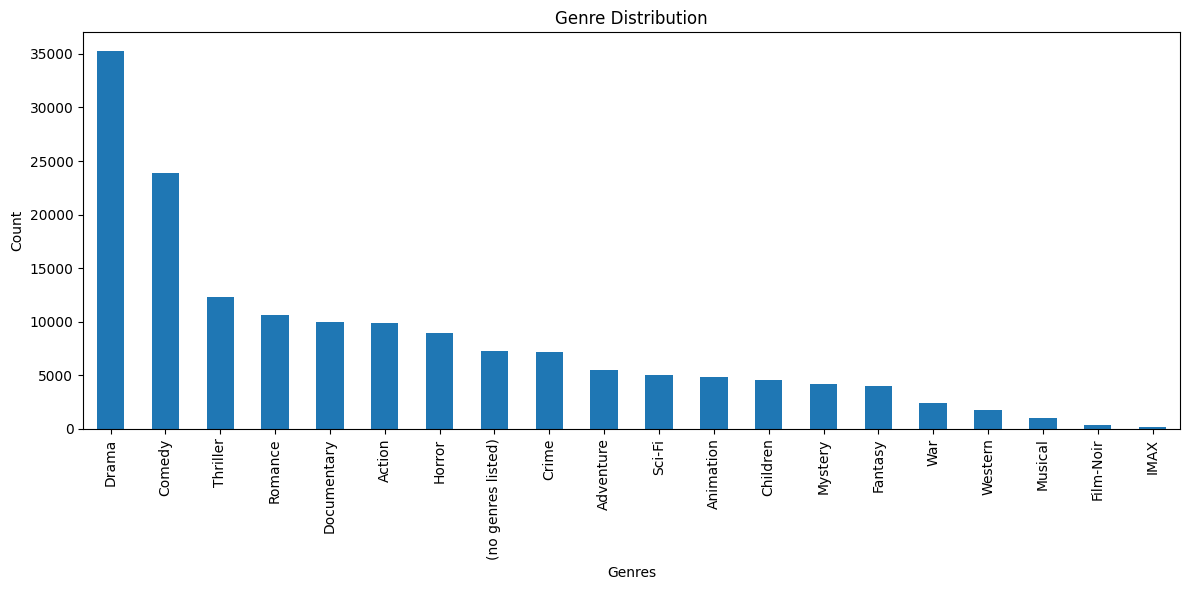

In [9]:
# Genre Analysis
print("\nGenre Distribution:")
movies_df['genres'] = movies_df['genres'].fillna('Unknown')
genre_counts = movies_df['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [21]:
# Multi-Genre Movies
multi_genre_movies = movies_df['genres'].str.contains('\|')
print("\n Multi-Genre Movies Statistics:")
print(f"Total Movies: {len(movies_df)}")
print(f"Movies with Multiple Genres: {multi_genre_movies.sum()}")
print(f"Percentage of Multi-Genre Movies: {multi_genre_movies.mean()*100:.2f}%")


 Multi-Genre Movies Statistics:
Total Movies: 90638
Movies with Multiple Genres: 44410
Percentage of Multi-Genre Movies: 49.00%


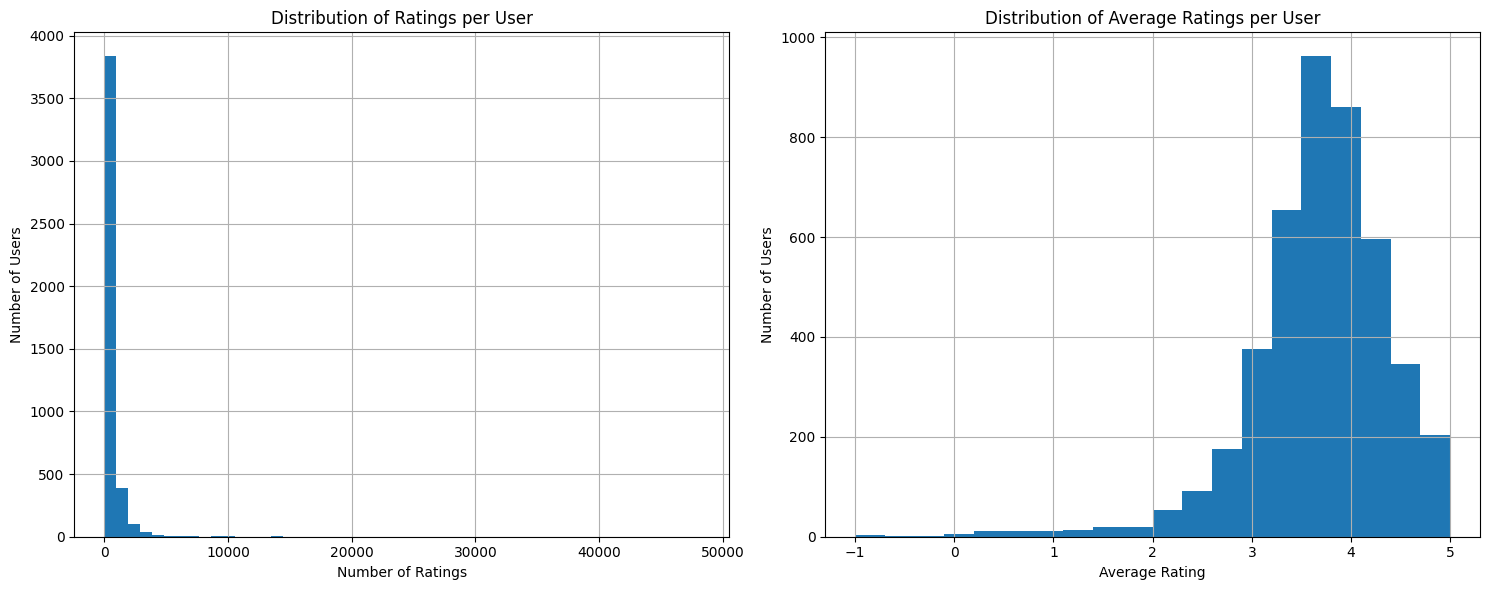

In [22]:
# User Rating Behavior
user_rating_stats = ratings_df.groupby('userId')['rating'].agg(['count', 'mean'])

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
user_rating_stats['count'].hist(bins=50)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
user_rating_stats['mean'].hist(bins=20)
plt.title('Distribution of Average Ratings per User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

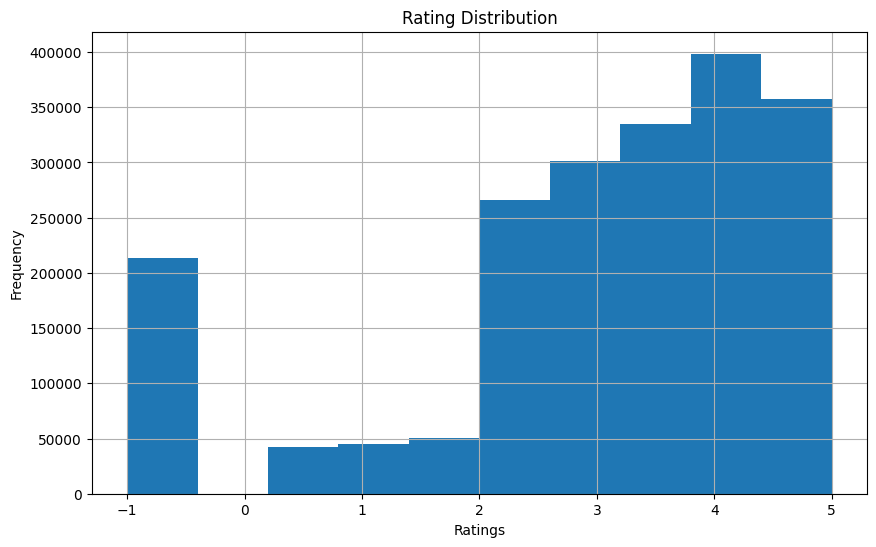

In [10]:
# Ratings Distribution
plt.figure(figsize=(10, 6))
ratings_df['rating'].hist(bins=10)
plt.title('Rating Distribution')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

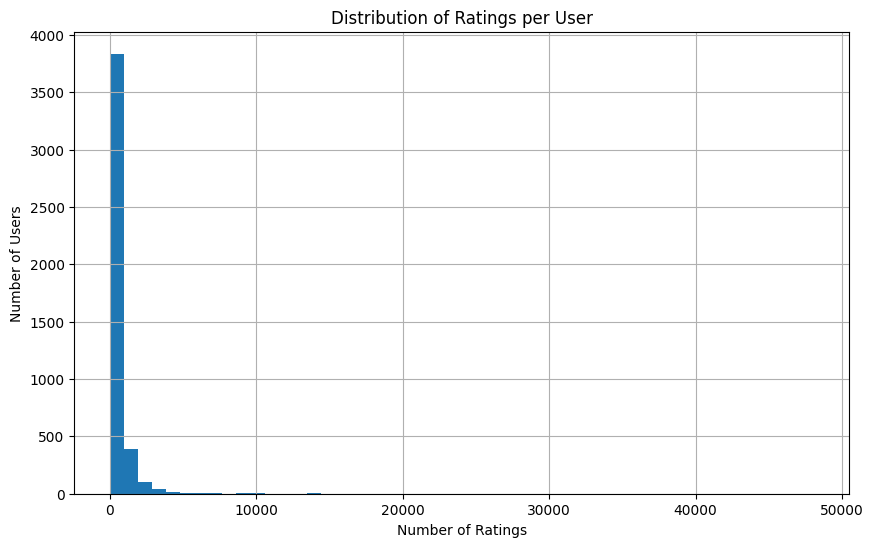

In [23]:
# User Rating Behavior
user_rating_counts = ratings_df.groupby('userId')['rating'].count()
plt.figure(figsize=(10, 6))
user_rating_counts.hist(bins=50)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

In [12]:
# Top Rated Movies
movie_avg_ratings = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count'])
top_rated = movie_avg_ratings[movie_avg_ratings['count'] > 50].sort_values('mean', ascending=False)
print("\nTop 10 Rated Movies (with > 50 ratings):")
top_rated_with_titles = top_rated.merge(movies_df[['movieId', 'title']], on='movieId').head(10)
print(top_rated_with_titles)


Top 10 Rated Movies (with > 50 ratings):
   movieId      mean  count                             title
0      318  4.096633   3653  Shawshank Redemption, The (1994)
1   296831  4.094728    607             Dune: Part Two (2024)
2      296  4.090345   2900               Pulp Fiction (1994)
3   202439  4.068365   2355                   Parasite (2019)
4     2959  4.063497   3260                 Fight Club (1999)
5   109487  4.019620   3160               Interstellar (2014)
6     2571  4.007469   3481                Matrix, The (1999)
7    79132  3.990096   3433                  Inception (2010)
8     1203  3.985410   1268               12 Angry Men (1957)
9    55820  3.964360   1936     No Country for Old Men (2007)


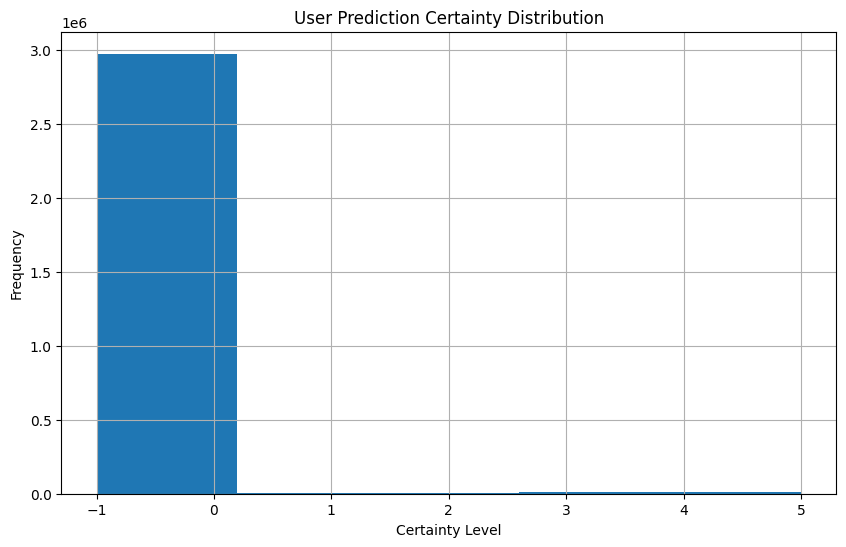

In [24]:
# User Prediction Certainty
plt.figure(figsize=(10, 6))
beliefs[beliefs['userCertainty'].notnull()]['userCertainty'].hist(bins=5)
plt.title('User Prediction Certainty Distribution')
plt.xlabel('Certainty Level')
plt.ylabel('Frequency')
plt.show()

### Preprocessing For Recommendation System

## Recommendation System - Models

### Content- Based Filtering

In [52]:
def content_based_recommendation(movies_df, movie_index, top_n=10):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Prepare the TF-IDF matrix
    tfidf = TfidfVectorizer(stop_words='english')
    movies_df['genres'] = movies_df['genres'].fillna('')
    genre_matrix = tfidf.fit_transform(movies_df['genres'])
    
    # Compute cosine similarity
    cosine_sim = cosine_similarity(
        genre_matrix[movie_index], 
        genre_matrix
    ).flatten()
    
    # Get indices of most similar movies
    similar_indices = cosine_sim.argsort()[-(top_n + 1):-1][::-1]
    
    # Return the movie IDs of similar movies
    return movies_df.iloc[similar_indices]['movieId'].tolist()

### Collaborative Filtering - SVD

In [ ]:
def popularity_based_recommendation(ratings_df, movies_df, top_n=5):

    movie_popularity = ratings_df['movieId'].value_counts()
    
    top_movie_ids = movie_popularity.head(top_n).index.tolist()
    
    return movies_df[movies_df['movieId'].isin(top_movie_ids)]['title'].tolist()

In [31]:
def collaborative_svd_recommendation(ratings_df, movies_df, user_id, top_n=5):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(
        ratings_df[['userId', 'movieId', 'rating']], 
        reader
    )
    
    # Split data
    trainset, _ = surprise_split(data, test_size=0.2)
    
    # Train SVD model
    svd = SVD(n_factors=100, n_epochs=20)
    svd.fit(trainset)
    
    # Get all movie IDs
    all_movie_ids = ratings_df['movieId'].unique()
    
    # Predict ratings for unseen movies
    predictions = []
    for movie_id in all_movie_ids:
        prediction = svd.predict(user_id, movie_id)
        predictions.append((movie_id, prediction.est))
    
    # Sort and get top recommendations
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [pred[0] for pred in predictions[:top_n]]
    
    return movies_df[movies_df['movieId'].isin(top_movie_ids)]['title'].tolist()

### Evaluation and Results

In [33]:
# Demonstration of recommendation methods
print("\nContent-Based Recommendations for 'Toy Story (1995)':")
print(content_based_recommendation(movies_df, 'Toy Story (1995)'))
   


Content-Based Recommendations for 'Toy Story (1995)':
["Olaf's Frozen Adventure (2017)", 'Bunyan and Babe (2017)', 'Hotel Transylvania: Transformania (2022)', 'Christmas in Tattertown (1988)', 'Antz (1998)']


In [ ]:
# SVD Based REcommendation for specific Users.
print("\nCollaborative SVD Recommendations for User 42170:")
print(collaborative_svd_recommendation(ratings_df, movies_df, 42170))

  


Collaborative SVD Recommendations for User 42170:
['Toy Story (1995)', 'Sabrina (1995)', 'Sense and Sensibility (1995)', 'Powder (1995)', 'Dead Man Walking (1995)']


In [47]:
# Just fetching the mostt popular recommendations
popular_recs = popularity_based_recommendation(ratings_df, movies_df)
print(popular_recs)

['Shawshank Redemption, The (1994)', 'Matrix, The (1999)', 'Fight Club (1999)', 'Dark Knight, The (2008)', 'Inception (2010)']
